In [1]:
from autograd.scipy.stats import norm 
from autograd.scipy.stats import gamma
import autograd.numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, unique, Column, hstack, vstack
from autograd import grad
from xdgmm import XDGMM
from autograd import hessian
from scipy.optimize import minimize
import matplotlib as mpl

In [2]:
import autograd.numpy as np
import autograd.numpy.linalg as npla
import autograd.scipy.misc as scpm

def mog_logprob(x, means, icovs, lndets, pis):
    """ compute the log likelihood according to a mixture of gaussians
        with means  = [mu0, mu1, ... muk]
             icovs  = [C0^-1, ..., CK^-1]
             lndets = ln [|C0|, ..., |CK|]
             pis    = [pi1, ..., piK] (sum to 1)
        at locations given by x = [x1, ..., xN]
    """
    xx = np.atleast_2d(x)
    D  = xx.shape[1]
    centered = xx[:,:,np.newaxis] - means.T[np.newaxis,:,:]
    solved   = np.einsum('ijk,lji->lki', icovs, centered)
    logprobs = - 0.5*np.sum(solved * centered, axis=1) - (D/2.)*np.log(2*np.pi) \
               - 0.5*lndets + np.log(pis)
    logprob  = scpm.logsumexp(logprobs, axis=1)
    if np.isscalar(x) or len(x.shape) == 1:
        return logprob[0]
    else:
        return logprob


In [57]:
def predicted_color(A, c, alpha=0.3):
    return c + A*alpha

def predicted_magnitude(A, M, d, beta=0.16):
    return M + A*beta + 5.*np.log10(d*1e3/10.)

def logjoint(theta, chat, mhat, varpihat, sigmac, sigmam, sigmavarpi, means, icovs, lndets,  pis, log=True):
    if log:
        lnA, M, c, lnd = theta
        A, d = np.exp(lnA), np.exp(lnd)
    else:
        A, M, c, d = theta

    lnp_c = norm.logpdf(chat, predicted_color(A, c), sigmac)
    lnp_m = norm.logpdf(mhat, predicted_magnitude(A, M, d), sigmam)
    lnp_varpi = norm.logpdf(varpihat, 1./d, sigmavarpi)
    lnp_Mc = mog_logprob(np.array([c,M]), means, icovs, lndets, pis)
    
    """
    if (A >= 0) & (A < 5):
        lnp_A = 0
    else:
        lnp_A = -np.inf
    
    if (d > 0) & (d < 10): 
        lnp_d = 0
    else: 
        lnp_d = -np.inf
    """
    #lnp_A = norm.logpdf(A, 0, 2)
    #lnp_d = norm.logpdf(d, 0, 10)
    lnp_A = 0. #norm.logpdf(A, 0, 10)
    lnp_d = 0. #norm.logpdf(d, 0, 10)
    #lnp_A = gamma.logpdf(A, 1) #, 0, 2)
    #lnp_d = norm.logpdf(d, 0, 10)
    #lnp_d = gamma.logpdf(d, 1) #, 0, 10)
    string = 'p(c):{0} p(m):{1} p(varpi):{2} p(Mc):{3} p(A):{4} p(d):{5}'.format(lnp_c, lnp_m, lnp_varpi, lnp_Mc, lnp_A, lnp_d)
    #print(string)
    return np.sum([lnp_c, lnp_m, lnp_varpi, lnp_Mc, lnp_A, lnp_d])

In [4]:
def plotXdgmm(xdgmm, ax, c='k', lw=1, label='prior', step=0.001):
    ts = np.arange(0, 2. * np.pi, step) #magic
    amps = xdgmm.weights
    mus = xdgmm.mu
    Vs = xdgmm.V
    for gg in range(xdgmm.n_components):
        if amps[gg] == np.max(amps):
            label=label
        else:
            label=None
        w, v = np.linalg.eigh(Vs[gg])
        points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
                 np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
                 mus[gg][:, None]
        ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=amps[gg]/np.max(amps), rasterized=True, label=label)

def plotgaussian1sigma(ax, mu, V, c='k', lw=1, label='prior', step=0.001, alpha=1.0):
    ts = np.arange(0, 2. * np.pi, step) #magic
    w, v = np.linalg.eigh(V)
    points = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
             np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
             mu[:, None]
    ax.plot(points[0,:], points[1,:], c, lw=lw, alpha=alpha, rasterized=True, label=label)
    return points

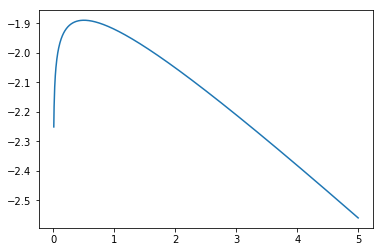

In [5]:
x = np.linspace(0, 5, 1000)
b = gamma.logpdf(0, 1)
plt.plot(x, gamma.logpdf(x, 1.1, 0, 5)) #, 0, 10))

In [97]:
ncomp = 256
w = 0.01
filename = 'rjce_fullcmd_sfd_0.0075_{0}w_{1}G.fits'.format(w, ncomp)
xdgmm = XDGMM(filename=filename, method='Bovy')
lndets = np.array([np.linalg.slogdet(s)[1] for s in xdgmm.V])
icovs = np.array([np.linalg.inv(s) for s in xdgmm.V])
means = xdgmm.mu
pis = xdgmm.weights


In [106]:
datahigh = Table.read('dustHighLat2-result.fits.gz')
datalow = Table.read('dustLowLat2-result.fits.gz')
data = vstack((datahigh, datalow))

In [15]:
data.keys()

['ra',
 'dec',
 'parallax',
 'parallax_error',
 'h_m',
 'h_msigcom',
 'w2mpro',
 'w2mpro_error',
 'phot_g_mean_mag',
 'phot_g_mean_flux_over_error',
 'phot_bp_mean_mag',
 'phot_bp_mean_flux_over_error',
 'phot_rp_mean_mag',
 'phot_rp_mean_flux_over_error',
 'j_m',
 'j_msigcom',
 'ks_m',
 'ks_msigcom',
 'w1mpro',
 'w1mpro_error']

In [107]:
indices = data['ruwe'] < 1.4
mhat = data['w2mpro'][indices]
w2hat = data['w2mpro'][indices]
hhat = data['h_m'][indices]
chat = data['h_m'][indices] - data['w2mpro'][indices]
varpihat = data['parallax'][indices]
absmaghat = mhat - 5.*np.log10(1./(varpihat/1e3*10))
sigmac = np.sqrt(data['h_msigcom'][indices]**2 + data['w2mpro_error'][indices]**2.)
sigmam = data['w2mpro_error'][indices]
sigmavarpi = data['parallax_error'][indices]
sigmaw2 = data['w2mpro'][indices]
sigmah = data['h_msigcom'][indices]

In [108]:
sample = xdgmm.sample(int(len(chat)/10))

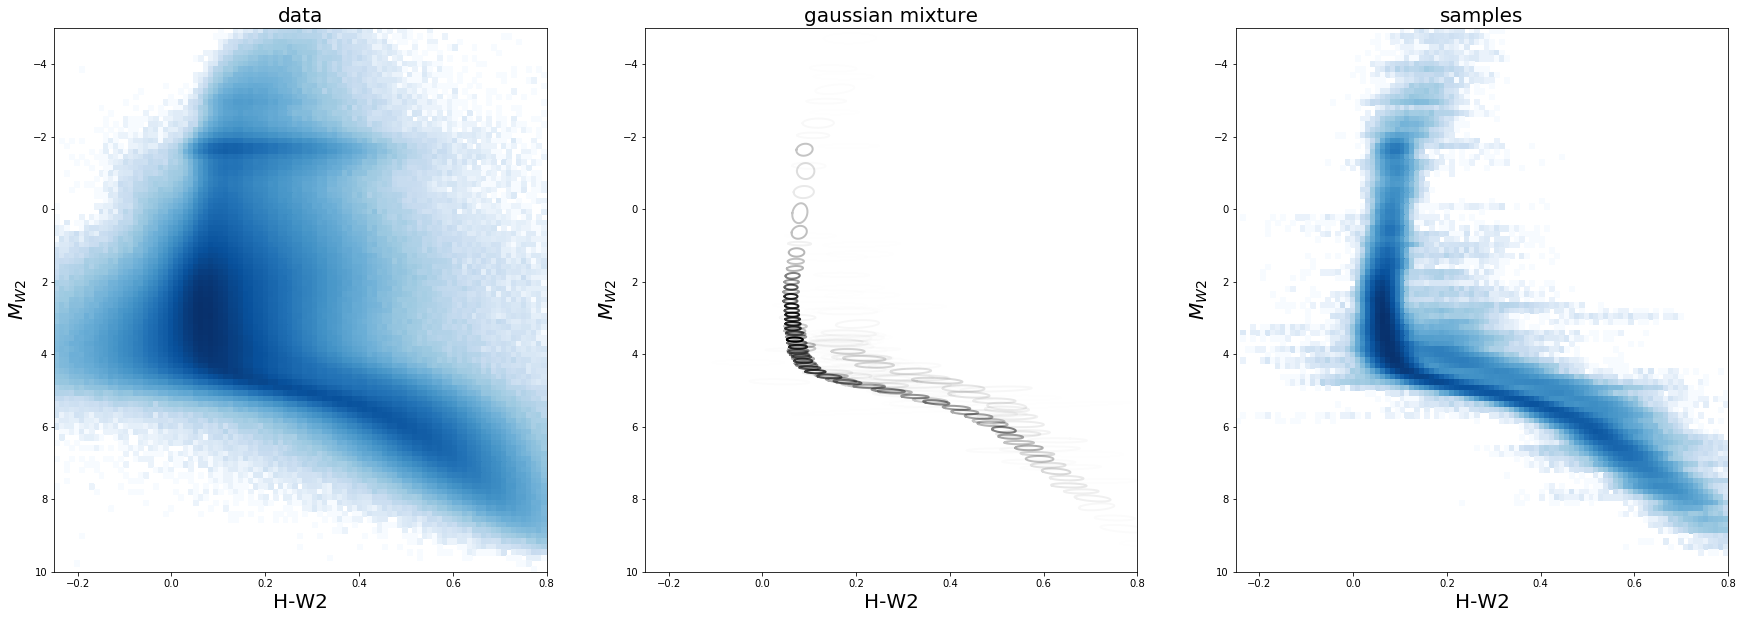

In [109]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

nbins = 100
xbins = np.linspace(-0.25, 0.8, nbins)
ybins = np.linspace(-5, 10, nbins)

for c, ab, a in zip([chat, sample[:,0]], [absmaghat, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)

labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(-0.25, 0.8)
    a.set_ylim(10, -5)
    a.set_title(l, fontsize=20)


In [110]:
xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

H, xe, ye = np.histogram2d(sample[:,0], 
                           sample[:,1], 
                           bins=(xbins, ybins))

xx, yy = np.meshgrid(xbins, ybins)
values = np.zeros(len(xx.flatten()))
for i, (x, y) in enumerate(zip(xx.flatten(), yy.flatten())):
    values[i] = mog_logprob(np.array([x, y]), means, icovs, lndets, pis)
values[values < -25] = -25


c: 0.532+/-0.048  m: 5.642+-0.090  varpi: 2.647+-0.086 distance: 0.378


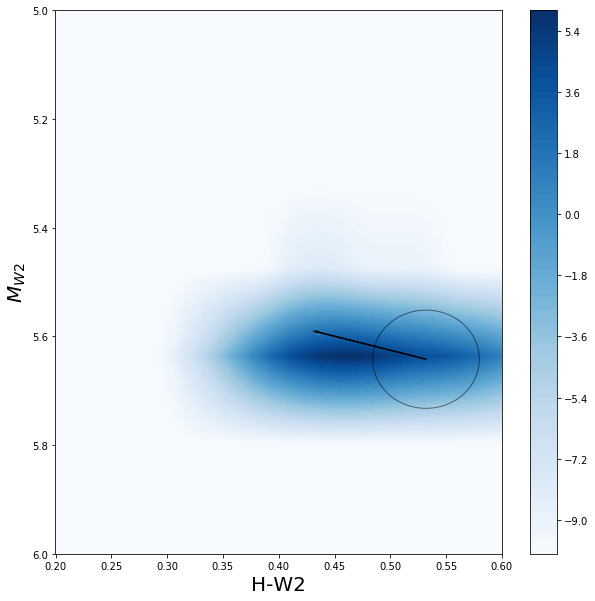

In [89]:
xx, yy = np.meshgrid(xbins, ybins)
#values = np.zeros(len(xx.flatten()))
#for i, (x, y) in enumerate(zip(xx.flatten(), yy.flatten())):
#    values[i] = mog_logprob(np.array([x, y]), means, icovs, lndets, pis)
#values[values < -5] = -5

A = 0.1
d = 0.378
logj = np.zeros(len(xx.flatten()))
for i, (x, y) in enumerate(zip(xx.flatten(), yy.flatten())):
    theta = [A, y, x, d]
    logj[i] = logjoint(theta, chat[16], mhat[16], varpihat[16], sigmac[16], sigmam[16], sigmavarpi[16], 
                       means, icovs, lndets,  pis, log=False)
logj[logj < -10] = -10

method='L-BFGS-B'
i = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

im = ax.contourf(xx, yy, logj.reshape(xx.shape), 100, cmap=plt.get_cmap('Blues'))
fig.colorbar(im,ax=ax)

for i in range(16, 17):
    args = (chat[i], mhat[i], varpihat[i], sigmac[i], sigmam[i], sigmavarpi[i], means, icovs, lndets, pis)
    kwargs = {'log':True}

    am = mhat[i] - 5.*np.log10(1./(varpihat[i]/1e3*10))
    theta_0 = np.array([-2, am, chat[i], np.log(1./varpihat[i])])
    #A, M, c d

    obj = lambda *args, **kwargs: -1.*logjoint(*args, **kwargs)
    gobj = grad(obj)
    hobj = hessian(obj)
    res = minimize(obj, theta_0, args=args, method=method, jac=gobj)
    theta_hat_ln = res.x
    theta_hat = np.array([np.exp(theta_hat_ln[0]), theta_hat_ln[1], theta_hat_ln[2], np.exp(theta_hat_ln[3])])
    #sigma_hat = np.linalg.inv(hobj(theta_hat, chat[i], mhat[i], 
    #                               varpihat[i], sigmac[i], sigmam[i], sigmavarpi[i], means, icovs, lndets, pis, log=False))

    #print('Dust: {0:.3f}+/-{1:0.3f}  Absmag: {2:0.3f}+-{3:0.3f}  color: {4:0.3f}+-{5:0.3f}  distance: {6:0.3f}+-{7:0.3f}'.format(theta_hat[0], np.sqrt(sigma_hat[0,0]), 
    #                                                                              theta_hat[1], np.sqrt(sigma_hat[1,1]),
    #                                                                              theta_hat[2], np.sqrt(sigma_hat[2,2]),
    #                                                                              theta_hat[3], np.sqrt(sigma_hat[3,3])))
    print('c: {0:.3f}+/-{1:0.3f}  m: {2:0.3f}+-{3:0.3f}  varpi: {4:0.3f}+-{5:0.3f} distance: {6:0.3f}'.format(chat[i], sigmac[i], 
                                                                                  am, np.sqrt(sigmam[i]**2 + sigmavarpi[i]**2),
                                                                                  varpihat[i], sigmavarpi[i],
                                                                                  1./varpihat[i]))


    
    #plotXdgmm(xdgmm, ax[1], lw=2)
    V = np.zeros((2,2))
    V[0,0] = sigmac[i]**2.
    V[1,1] = sigmam[i]**2 + sigmavarpi[i]**2
    p = plotgaussian1sigma(ax, np.array([chat[i], am]), V, alpha=0.5) 
    #V = np.zeros((2,2))
    #V[0,0] = sigma_hat[2,2]
    #V[1,0] = sigma_hat[2,1]
    #V[0,1] = sigma_hat[1,2]
    #V[1,1] = sigma_hat[1,1]
    #p = plotgaussian1sigma(ax, np.array([theta_hat[2], theta_hat[1]]), V, c='red')
    plt.scatter(theta_hat[2], theta_hat[1])
    #A, M, c, d = theta
    plt.arrow(chat[i], am, theta_hat[2] - chat[i], theta_hat[1] - am)

    ax.set_xlabel('H-W2', fontsize=20)
    ax.set_ylabel('$M_{W2}$', fontsize=20)
    ax.set_xlim(0.2, 0.6)
    ax.set_ylim(6, 5)
    #ax.set_title(l, fontsize=20)
plt.savefig('posteriors.png', rasterized=True)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in add
  return f_raw(*args, **kwargs)
/anaconda3/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)


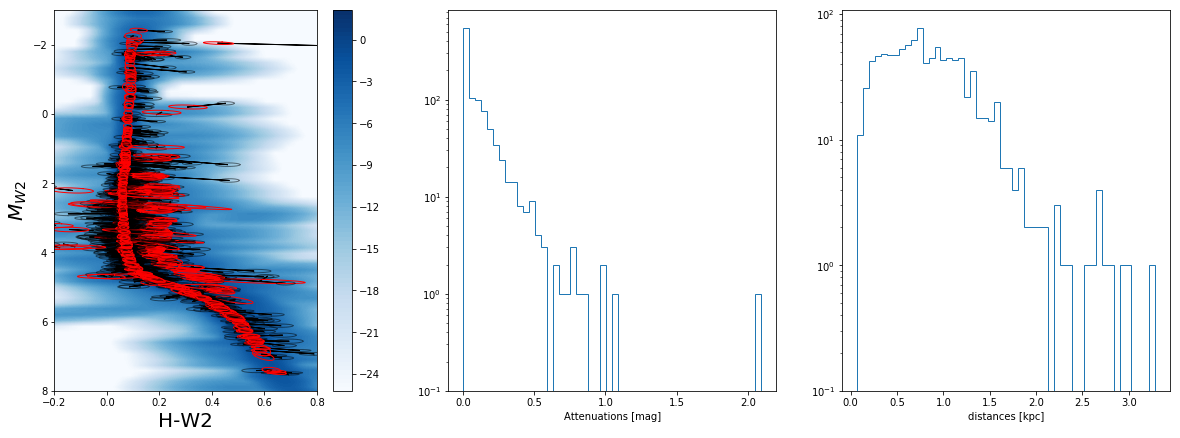

In [118]:
method='L-BFGS-B'
#method = 'Nelder-Mead'
i = 1
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

ax = axes[0]
im = ax.contourf(xx, yy, values.reshape(xx.shape), 100, cmap=plt.get_cmap('Blues') ) #vmin=-20, vmax=2.5, )
fig.colorbar(im,ax=ax)
#np.random.seed(0)
n = 1000
A = np.zeros(n)
d = np.zeros(n)
for j in range(0, n):
    i = np.random.randint(0, len(chat))
    args = (chat[i], mhat[i], varpihat[i], sigmac[i], sigmam[i], sigmavarpi[i], means, icovs, lndets, pis)
    kwargs = {'log':True}

    am = mhat[i] - 5.*np.log10(1./(varpihat[i]/1e3*10))
    theta_0 = np.array([np.log(0.01), am, chat[i], np.log(1./varpihat[i])])
    #A, M, c d

    obj = lambda *args, **kwargs: -1.*logjoint(*args, **kwargs)
    gobj = grad(obj)
    hobj = hessian(obj)
    res = minimize(obj, theta_0, args=args, method=method, jac=gobj)
    theta_hat_ln = res.x
    theta_hat = np.array([np.exp(theta_hat_ln[0]), theta_hat_ln[1], theta_hat_ln[2], np.exp(theta_hat_ln[3])])
    sigma_hat = np.linalg.inv(hobj(theta_hat, chat[i], mhat[i], 
                                   varpihat[i], sigmac[i], sigmam[i], sigmavarpi[i], means, icovs, lndets, pis, log=False))

    #print('Dust: {0:.3f}+/-{1:0.3f}  Absmag: {2:0.3f}+-{3:0.3f}  color: {4:0.3f}+-{5:0.3f}  distance: {6:0.3f}+-{7:0.3f}'.format(theta_hat[0], np.sqrt(sigma_hat[0,0]), 
    #                                                                                theta_hat[1], np.sqrt(sigma_hat[1,1]),
    #                                                                              theta_hat[2], np.sqrt(sigma_hat[2,2]),
    #                                                                              theta_hat[3], np.sqrt(sigma_hat[3,3])))
    #print('c: {0:.3f}+/-{1:0.3f}  m: {2:0.3f}+-{3:0.3f}  varpi: {4:0.3f}+-{5:0.3f} distance: {6:0.3f}'.format(chat[i], sigmac[i], 
    #                                                                              am, np.sqrt(sigmam[i]**2 + sigmavarpi[i]**2),
    #                                                                              varpihat[i], sigmavarpi[i],
    #                                                                              1./varpihat[i]))


    
    #plotXdgmm(xdgmm, ax[1], lw=2)
    V = np.zeros((2,2))
    V[0,0] = sigmac[i]**2.
    V[1,1] = sigmam[i]**2 + (sigmavarpi[i]/varpihat[i])**2
    p = plotgaussian1sigma(ax, np.array([chat[i], am]), V, alpha=0.5) 
    V = np.zeros((2,2))
    V[0,0] = sigma_hat[2,2]
    V[1,0] = sigma_hat[2,1]
    V[0,1] = sigma_hat[1,2]
    V[1,1] = sigma_hat[1,1]
    p = plotgaussian1sigma(ax, np.array([theta_hat[2], theta_hat[1]]), V, c='red')
    #A, M, c, d = theta
    ax.arrow(chat[i], am, theta_hat[2] - chat[i], theta_hat[1] - am)
    A[j] = theta_hat[0]
    d[j] = theta_hat[3]
    ax.set_xlabel('H-W2', fontsize=20)
    ax.set_ylabel('$M_{W2}$', fontsize=20)
    ax.set_xlim(-0.2, 0.8)
    ax.set_ylim(8, -3)
    #ax.set_title(l, fontsize=20)
axes[1].hist(A, bins=50, log=True, histtype='step')
axes[1].set_xlabel('Attenuations [mag]')
axes[2].hist(d, bins=50, log=True, histtype='step')
axes[2].set_xlabel('distances [kpc]')
plt.savefig('posteriors.png', rasterized=True)


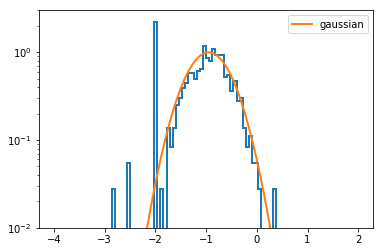

In [132]:
plt.hist(np.log10(A), log=True, range=[-4, 2], bins=100, normed=True, histtype='step', lw=2);
x = np.linspace(-3, 1, 100)
plt.plot(x, norm.pdf(x, loc=-0.95, scale=0.4), lw=2, label='gaussian')
plt.legend()
plt.ylim(1e-2,3)
plt.savefig('lognormdistributed.pdf')

In [72]:
res.x

array([ 0.01      ,  5.64301095,  0.44658368, -0.98027598])

In [83]:
xdgmm.bic

<bound method XDGMM.bic of XDGMM(V=array([[[ 8.83167e-03, -3.50966e-04],
        [-3.50966e-04,  8.87972e-03]],

       [[ 9.93569e-03, -9.17648e-06],
        [-9.17648e-06,  9.97797e-03]],

       ...,

       [[ 2.98985e-04, -2.12431e-04],
        [-2.12431e-04,  4.68344e-03]],

       [[ 3.33000e-03, -1.67414e-04],
        [-1.67414e-04,  7.42693e-03]]]),
   filename=None, labels=None, method='Bovy',
   mu=array([[0.3656 , 5.36105],
       [0.17668, 2.70841],
       ...,
       [0.0696 , 1.6301 ],
       [0.15677, 3.6692 ]]),
   n_components=256, n_iter=1000000000, random_state=None, tol=1e-05,
   w=None,
   weights=array([2.18927e-04, 1.57400e-06, ..., 9.54674e-03, 1.08433e-03]))>

In [38]:
sigma_hat[3,3]

0.00045406803345703826

In [36]:
theta_hat[3]

0.836426578075457

In [43]:
from scipy.integrate import simps
simps(simps(np.exp(values).reshape(xx.shape), ye), xe)

1.041071486714874

NameError: name 'xx' is not defined

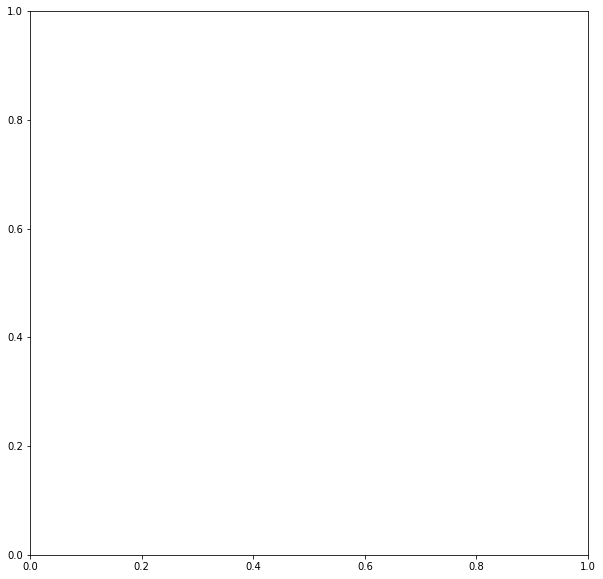

In [16]:
method='L-BFGS-B'
i = 1
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

im = ax.contourf(xx, yy, values.reshape(xx.shape), 100, vmin=-10, vmax=10)
fig.colorbar(im,ax=ax)
#im.set_rasterized(True)


for j in range(0, 20):
    i = np.random.randint(0, len(bright))
    args = (chat[bright[i]], mhat[bright[i]], varpihat[bright[i]], sigmac[bright[i]], sigmam[bright[i]], sigmavarpi[bright[i]], pis, means, icovs, lndets, xdgmm)
    kwargs = {'log':True}
    theta_0 = np.array([0.1, 2., 0.08, 1.0])

    obj = lambda *args: -1.*logjoint(*args, **kwargs)
    gobj = grad(obj)
    hobj = hessian(obj)
    res = minimize(obj, theta_0, args=args, method=method, jac=gobj)
    theta_hat = res.x
    sigma_hat = np.linalg.inv(hobj(theta_hat, chat[bright[0]], mhat[bright[0]], 
                                   varpihat[bright[0]], sigmac[bright[0]], sigmam[bright[0]], sigmavarpi[bright[0]], pis, means, icovs, lndets, xdgmm))

    print('Dust: {0:.3f}+/-{1:0.3f}  Absmag: {2:0.3f}+-{3:0.3f}  color: {4:0.3f}+-{5:0.3f}  distance: {6:0.3f}+-{7:0.3f}'.format(theta_hat[0], np.sqrt(sigma_hat[0,0]), 
                                                                                  theta_hat[1], np.sqrt(sigma_hat[1,1]),
                                                                                  theta_hat[2], np.sqrt(sigma_hat[2,2]),
                                                                                  theta_hat[3], np.sqrt(sigma_hat[3,3])))


    am = mhat[bright[i]] - 5.*np.log10(1./(varpihat[bright[i]]/1e3*10))
    #plotXdgmm(xdgmm, ax[1], lw=2)
    V = np.zeros((2,2))
    V[0,0] = sigmac[0]**2.
    V[1,1] = sigmam[0]**2 + sigmavarpi[0]**2
    p = plotgaussian1sigma(ax, np.array([chat[bright[i]], am]), V, alpha=0.5) 
    V = np.zeros((2,2))
    V[0,0] = sigma_hat[2,2]
    V[1,0] = sigma_hat[2,1]
    V[0,1] = sigma_hat[1,2]
    V[1,1] = sigma_hat[1,1]
    p = plotgaussian1sigma(ax, np.array([theta_hat[2], theta_hat[1]]), V, c='red')
    #A, M, c, d = theta

    plt.arrow(chat[bright[i]], am, theta_hat[2] - chat[bright[i]], theta_hat[1] - am)

    ax.set_xlabel('H-W2', fontsize=20)
    ax.set_ylabel('$M_{W2}$', fontsize=20)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim[::-1])
    #ax.set_title(l, fontsize=20)
plt.savefig('posteriors.png', rasterized=True)


In [ ]:
p(c):-6.217428764152867 p(m):-49.720487084570664 p(varpi):-2857.7659418150315 p(Mc):-4.268768121303194 p(A):-0.1 p(d):-1.0
p(c):-21.72984608241658 p(m):-533.6503819365388 p(varpi):-1937.6469227094653 p(Mc):-7.56569717726221 p(A):-0.053345126719801426 p(d):-0.7029512825086909                        

In [ ]:
lnp_c,             lnp_m,                lnp_varpi,           lnp_Mc,             lnp_A,             lnp_d
2.1611949728028126 -90.33760374614414 -21.50742721543208 -12.24564139236691 -0.9239385332046727 -3.2265236261987185
-8.424173677612075 -14.177497800096212 -37.45983009577268 4.6380018062232455 -0.9675665739445588 -3.2262035033735943


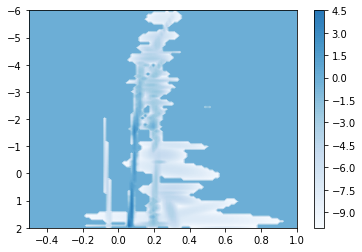

In [132]:



plt.contourf(xx, yy, values.reshape(xx.shape), 100, vmin=-10, vmax=10, cmap=plt.get_cmap('Blues'))
plt.colorbar()
plt.gca().invert_yaxis()


In [97]:
np.exp(values)

array([1.16418836e-70, 4.14685565e-68, 1.31460877e-65, ...,
       4.95010911e-06, 4.42437444e-06, 3.93845198e-06])

NameError: name 'sigma_hat' is not defined

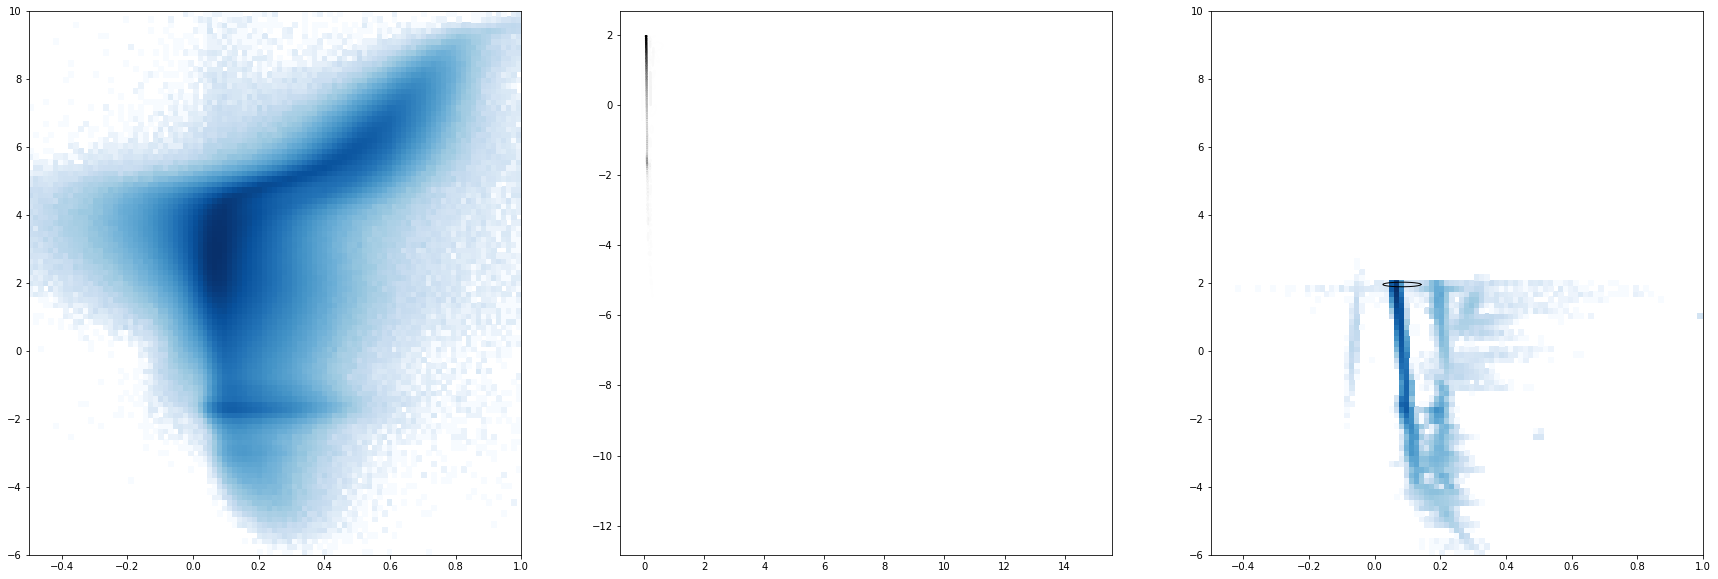

In [51]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

xlim = [-0.5, 1.0]
ylim = [-6, 10]
nbins = 100
xbins = np.linspace(xlim[0], xlim[1], nbins)
ybins = np.linspace(ylim[0], ylim[1], nbins)

for c, ab, a in zip([chat, sample[:,0]], [absmag, sample[:,1]], [ax[0], ax[2]]):
    H, xe, ye = np.histogram2d(c, 
                           ab, 
                           bins=(xbins, ybins))
    im = a.pcolormesh(xe, ye, H.T,
      norm=mpl.colors.LogNorm(), cmap=plt.get_cmap('Blues'))#vmax=75))#, vmax=20) #, vmin=-100, vmax=100)
    im.set_rasterized(True)

plotXdgmm(xdgmm, ax[1], lw=2)
V = np.zeros((2,2))
V[0,0] = sigmac[0]**2.
V[1,1] = sigmam[0]**2 + sigmavarpi[0]**2
p = plotgaussian1sigma(ax[2], np.array([chat[bright[i]], mhat[bright[i]] - 5.*np.log10(1./(varpihat[bright[i]]/1e3*10))]), V) 
V = np.zeros((2,2))
V[0,0] = sigma_hat[2,2]
V[1,0] = sigma_hat[2,1]
V[0,1] = sigma_hat[1,2]
V[1,1] = sigma_hat[1,1]
p = plotgaussian1sigma(ax[2], np.array([theta_hat[2], theta_hat[1]]), V)
#A, M, c, d = theta
labels = ['data', 'gaussian mixture', 'samples']

for a , l in zip(ax, labels):
    a.set_xlabel('H-W2', fontsize=20)
    a.set_ylabel('$M_{W2}$', fontsize=20)
    a.set_xlim(xlim)
    a.set_ylim(ylim[::-1])
    a.set_title(l, fontsize=20)

In [ ]:
theta_hat

In [ ]:
print(p)

In [81]:
plot gmm
plot chat, mhat-> Mhat
plot c, M
plot arrow


(0.09899984741210943,
 14.061,
 1.165034815943981,
 0.058051702036715704,
 0.039,
 0.055317342303344876,
 array([6.33139839e-04, 1.86296822e-03, 5.88131355e-03, 2.08169037e-03,
        3.98768584e-03, 3.20725078e-04, 4.19642460e-03, 9.39181768e-04,
        2.00968955e-03, 3.88977587e-03, 3.18107534e-03, 1.24670535e-03,
        4.19633828e-06, 1.54414486e-02, 3.78180113e-04, 4.04491059e-03,
        6.09542552e-03, 7.69332793e-04, 2.12884917e-03, 1.32317844e-03,
        8.41272472e-03, 2.30433187e-04, 2.07959393e-03, 8.39369688e-06,
        8.47595911e-05, 1.03095756e-02, 1.12067270e-02, 1.09590028e-02,
        4.19633828e-06, 3.02233138e-03, 2.41416290e-03, 1.25756630e-02,
        4.24724977e-05, 2.96082477e-03, 2.61581569e-03, 2.42697053e-03,
        4.19890549e-03, 4.65168304e-03, 4.96451001e-03, 1.00604227e-02,
        4.56487778e-03, 1.51879457e-02, 1.91853789e-03, 1.93822422e-04,
        4.04683459e-03, 1.91932535e-02, 4.19633828e-06, 3.03952744e-04,
        5.10863492e-03, 7.25615